In [2]:
import numpy as np
import sklearn
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
SIZE = 28
meta = pd.read_csv('metadata.csv', delimiter=',')
data = np.loadtxt(f'hmnist_{SIZE}_{SIZE}_L.csv', delimiter=',', skiprows=1, usecols=range(SIZE * SIZE))

folder = "./baseline-lr0.001-epoch50-batchsize32"
labels = list(meta.dx.unique())

In [4]:
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

# Extract test data before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(data, to_categorical(label_encoder.fit_transform(meta.dx)), test_size=0.2, random_state=42069)

# Add SMOTE data to validate & train datas
smote = SMOTE(k_neighbors=5, random_state=42069)
X_train, y_train = smote.fit_resample(X_train, y_train)

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.25, random_state=42069)


2023-03-15 16:26:02.052625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 16:26:02.465227: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 16:26:02.465243: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-15 16:26:03.901002: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [5]:
X_tr = np.array(X_train).reshape(len(X_train), SIZE, SIZE)
X_test = np.array(X_test).reshape(len(X_test), SIZE, SIZE)
X_validate = np.array(X_validate).reshape(len(X_validate), SIZE, SIZE)


X_tr = X_tr[:, :, :, None]
X_test = X_test[:, :, :, None]
X_validate = X_validate[:, :, :, None]

In [6]:
import keras
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# model = keras.models.load_model(folder)

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='leaky_relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(7, activation='softmax'))
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_tr, y_train, epochs=20, batch_size=32, validation_data=(X_validate, y_validate))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2704)              0         
                                                                 
 dense (Dense)               (None, 7)                 18935     
                                                                 
Total params: 19,095
Trainable params: 19,095
Non-trainable params: 0
_________________________________________________________________


2023-03-15 16:26:08.184432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 16:26:08.185495: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 16:26:08.185719: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-15 16:26:08.185805: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-15 16:26:08.185911: W tensorflow/c

Epoch 1/20
881/881 [==============================] - 5s 4ms/step - loss: 4.3582 - accuracy: 0.4100 - val_loss: 1.2573 - val_accuracy: 0.5777
Epoch 2/20
881/881 [==============================] - 4s 4ms/step - loss: 1.1293 - accuracy: 0.6245 - val_loss: 1.0722 - val_accuracy: 0.6503
Epoch 3/20
881/881 [==============================] - 4s 4ms/step - loss: 0.9229 - accuracy: 0.6950 - val_loss: 0.9905 - val_accuracy: 0.6586
Epoch 4/20
881/881 [==============================] - 4s 4ms/step - loss: 0.8108 - accuracy: 0.7289 - val_loss: 0.9524 - val_accuracy: 0.7008
Epoch 5/20
881/881 [==============================] - 4s 4ms/step - loss: 0.7393 - accuracy: 0.7535 - val_loss: 0.7277 - val_accuracy: 0.7593
Epoch 6/20
881/881 [==============================] - 4s 4ms/step - loss: 0.6711 - accuracy: 0.7793 - val_loss: 0.8249 - val_accuracy: 0.7445
Epoch 7/20
881/881 [==============================] - 4s 4ms/step - loss: 0.6529 - accuracy: 0.7813 - val_loss: 0.7007 - val_accuracy: 0.7813
Epoch 

In [7]:
def plot_model_history(model_history):
    print(model_history.history.keys)
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    # axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])//10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    # axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

294/294 [==============================] - 0s 1ms/step - loss: 0.5626 - accuracy: 0.8533
Validation: accuracy = 0.853342  ;  loss = 0.562599
<built-in method keys of dict object at 0x7fea59e1ef00>


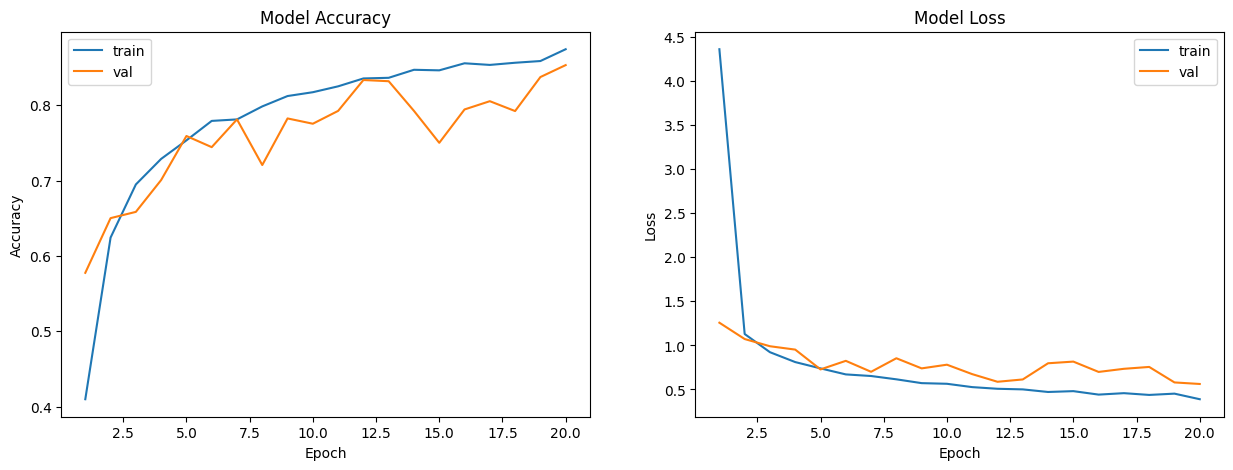

In [8]:
# test = model.evaluate(X_test, y_test)

# model = keras.models.load_model("./baseline-lr0.001-epoch150-batchsize32")
loss, accuracy = model.evaluate(X_validate, y_validate, verbose=1)
# loss_v, accuracy_v = model.evaluate(X_validate, y_validate, verbose=1)
# print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))

print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))
plot_model_history(history)

In [9]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

63/63 [==============================] - 0s 1ms/step
(2003, 7)
63/63 [==============================] - 0s 3ms/step - loss: 3.4992 - accuracy: 0.5137
Test: accuracy = 0.513729  ;  loss = 3.499161


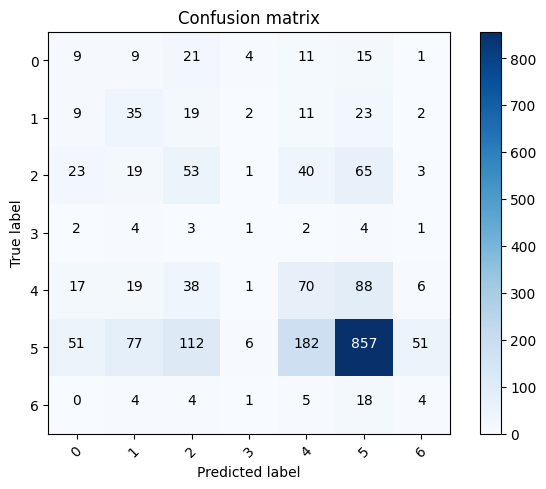

In [10]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
print(Y_pred.shape)
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
Y_true = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

loss_t, accuracy_t = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy_t, loss_t))

In [11]:
from sklearn.metrics import classification_report

model.save(folder)

with open(folder + "/scores.txt", "w") as f:
    f.write(classification_report(Y_true, Y_pred.argmax(axis=1), target_names=labels))


INFO:tensorflow:Assets written to: ./baseline-lr0.001-epoch50-batchsize32/assets


INFO:tensorflow:Assets written to: ./baseline-lr0.001-epoch50-batchsize32/assets
